### Forecasting hourly wind power production from multiple numerical weather predictions

#### Import relevant libraries

In [2812]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from tqdm import tqdm
from tqdm.notebook import tnrange
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import sweetviz
import xgboost as xgb

#### Load datasets

In [2051]:
df_Xtrain_raw = pd.read_csv("X_train_v2.csv")
df_Xtest_raw = pd.read_csv("X_test_v2.csv")
df_ytrain_raw = pd.read_csv("Y_train.csv")
df_ytest = pd.read_csv("Y_test_random.csv")

df_comp = pd.read_csv('WindFarms_complementary_data.csv',
                      encoding = "ISO-8859-1", sep=';' )

### Exploratory data analysis

##### Summary info of train and test set

In [2158]:
df_Xtrain_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37375 entries, 0 to 37374
Columns: 105 entries, ID to NWP4_12h_D_CLCT
dtypes: float64(102), int64(1), object(2)
memory usage: 29.9+ MB


In [2159]:
df_Xtest_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36529 entries, 0 to 36528
Columns: 105 entries, ID to NWP4_12h_D_CLCT
dtypes: float64(102), int64(1), object(2)
memory usage: 29.3+ MB


##### Check for missing values

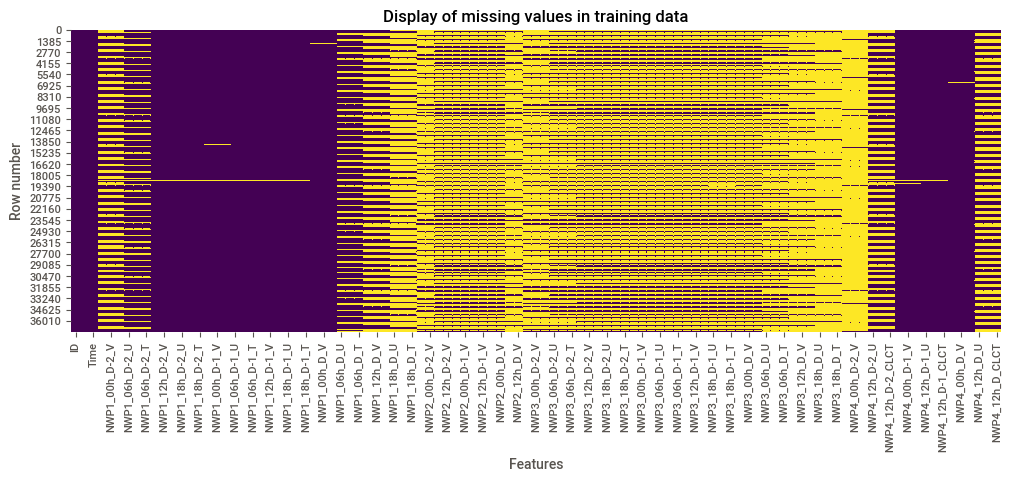

In [2751]:
plt.figure(figsize = (12,4))
sns.heatmap(df_Xtrain_raw.isnull(), cbar=False, cmap='viridis')
plt.title('Display of missing values in training data')
plt.xlabel('Features')
plt.ylabel('Row number');

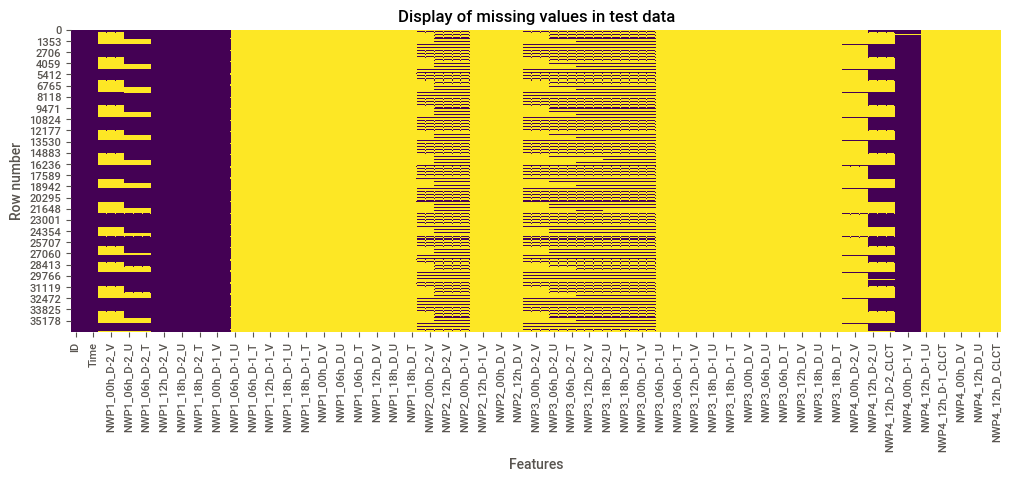

In [2754]:
plt.figure(figsize = (12,4))
sns.heatmap(df_Xtest_raw.isnull(), cbar=False, cmap='viridis')
plt.title('Display of missing values in test data')
plt.xlabel('Features')
plt.ylabel('Row number');

### Pre-process datasets

In [2172]:
df_train_raw = pd.concat([df_Xtrain_raw, df_ytrain_raw['Production']], axis=1)

In [2686]:
## Remove first two days of data across all wind farms (rows) in training data
for i, WF in enumerate(df_Xtrain_raw.WF.unique()):
    df_train_temp = df_train_raw[df_train_raw.WF == WF].iloc[47:]
    if i > 0:
        df_train_processed = pd.concat([df_train_processed, df_train_temp])
    else:
        df_train_processed = df_train_temp
    
df_train_processed.reset_index(drop=True, inplace=True)   

In [2687]:
df_Xtrain_processed = df_train_processed.iloc[:, :-1]
df_ytrain_processed = df_train_processed.iloc[:, -1:]

##### Handle missing values

In [2688]:
# Take the average of the latest 3 available predictions for each model
def latest_priority_gap_filler(df, NWPs, params):
    for i, NWP in enumerate(NWPs):
        for j, param in enumerate(params):
            cols = [col for col in df.columns if (NWP in col and param in col)]
            df_temp = pd.DataFrame(df[cols].apply(lambda x: np.mean([a for a in x if str(a) != 'nan'][-3:])\
                                                  if len([a for a in x if str(a) != 'nan']) > 0 else np.NAN,
                                                  axis=1), columns=[NWP+param])
            
            if i > 0 or j > 0:
                df_params = pd.concat([df_params, df_temp], axis=1)
            else:
                df_params = df_temp
                
    # drop non-applicable columns based on knowledge of data
    df_params.drop(['NWP2_T', 'NWP4_T', 'NWP1_CLCT', 'NWP2_CLCT', 'NWP3_CLCT'], axis=1, inplace=True)
    
    return df_params      

In [2689]:
NWPs = ['NWP1', 'NWP2', 'NWP3', 'NWP4']
params = ['_U', '_V', '_T', '_CLCT']

In [2755]:
%%time
df_params_train = latest_priority_gap_filler(df_Xtrain_processed, NWPs, params)

Wall time: 9.44 s


In [2756]:
%%time
df_params_test = latest_priority_gap_filler(df_Xtest_processed, NWPs, params)

Wall time: 7.15 s


In [2757]:
# Take the average of the available predictions for each variable
def replace_nan_with_mean_across_models(df):
    for i, param in enumerate(params):
        cols = [col for col in df.columns if param in col]
        df_temp = df[cols].copy()
        df_temp['avg'] = df_temp.apply(np.mean, axis=1)
        for col in df_temp.columns:
            if col != 'avg' and ('U' in col or 'V' in col):
                df_temp[col].fillna(df_temp['avg'], inplace=True)
            elif col != 'avg' and not ('U' in col or 'V' in col):
                df_temp[col].fillna(df_temp['avg'], inplace=True)
            else:
                pass
        
        df_temp.drop(['avg'], axis=1, inplace=True)
        if i > 0:
            df_X = pd.concat([df_X, df_temp], axis=1)
        else:
            df_X = df_temp
    
    return df_X

In [2758]:
## look through each column and replace nan values with latest available value in the column
# Take the average of the available predictions for each variable
def replace_nan_with_mean_latest_values(df):
    df_X = df.copy()
    for col in df_X.columns:
        indexx = df_X[col].index[df_X[col].apply(np.isnan)]
        if len(indexx) > 0:
            for ii in indexx:
                df_X[col].iloc[ii] = np.mean(df_X[col].iloc[:ii][-3:])
                
    df_XX = replace_nan_with_mean_across_models(df_X)
          
    return df_XX

In [2759]:
%%time
df_Xtrain_temp = replace_nan_with_mean_latest_values(df_params_train)

Wall time: 59.7 s


In [2760]:
%%time
df_Xtest_temp = replace_nan_with_mean_latest_values(df_params_test)

Wall time: 1min 13s


#### Feature engineering

In [2761]:
# Compute magnitude and direction of wind from components
def compute_mag_dir(df, NWPs):
    df_X = df.copy()
    for NWP in NWPs:
        cols = [col for col in df_X.columns if (NWP in col and ('U' in col or 'V' in col))]
        df_X[NWP+'_'+'Vmag'] = df_X[cols].apply(lambda x: np.sqrt(x[NWP+'_'+'U']**2 + x[NWP+'_'+'V']**2), axis=1)
        df_X[NWP+'_'+'Vdir'] = df_X[cols].apply(lambda x: np.arctan(x[NWP+'_'+'V']/x[NWP+'_'+'U']) \
                                                if x[NWP+'_'+'U'] != 0 else 0, axis=1)

    return df_X

In [2793]:
%%time
df_Xtrain_temp2 = compute_mag_dir(df_Xtrain_temp, NWPs)

Wall time: 7.72 s


In [2769]:
%%time
df_Xtest_temp2 = compute_mag_dir(df_Xtest_temp, NWPs)

Wall time: 7.88 s


In [2794]:
%%time
df_Xtrain_temp2['hour_sin'] = [np.sin(int(df_Xtrain_processed.Time.iloc[i].split(" ")[1][:2])*(2.*np.pi/24)) 
                               for i in range(len(df_Xtrain_processed))]
df_Xtrain_temp2['hour_cos'] = [np.cos(int(df_Xtrain_processed.Time.iloc[i].split(" ")[1][:2])*(2.*np.pi/24)) 
                               for i in range(len(df_Xtrain_processed))]

Wall time: 1.03 s


In [2771]:
%%time
df_Xtest_temp2['hour_sin'] = [np.sin(int(df_Xtest_raw.Time.iloc[i].split(" ")[1][:2])*(2.*np.pi/24)) for i in range(len(df_Xtest_raw))]
df_Xtest_temp2['hour_cos'] = [np.cos(int(df_Xtest_raw.Time.iloc[i].split(" ")[1][:2])*(2.*np.pi/24)) for i in range(len(df_Xtest_raw))]

Wall time: 955 ms


##### Add complementary data

In [2772]:
def include_comp_info(df_X, df_comp):
    for i, WF in enumerate(df_X.WF.unique()):
        df_xtemp = df_X[df_X.WF == WF].copy()
        df_xtemp['n_turbines'] = np.float(df_comp[df_comp['Wind Farm'] == WF]['Wind Turbine'].nunique())
        if i > 0:
            df_XX = pd.concat([df_XX, df_xtemp])
        else:
            df_XX = df_xtemp

    return df_XX

In [2773]:
df_Xtrain_temp2['WF'] = df_Xtrain_processed.WF

In [2774]:
df_Xtest_temp2['WF'] = df_Xtest_raw.WF

In [2775]:
%%time
df_Xtrain_temp3 = include_comp_info(df_Xtrain_temp2, df_comp)

Wall time: 178 ms


In [2776]:
%%time
df_Xtest_temp3 = include_comp_info(df_Xtest_temp2, df_comp)

Wall time: 155 ms


##### One-hot encoding of wind farm name

In [2777]:
df_Xtrain = pd.get_dummies(df_Xtrain_temp3, columns=['WF'],
                           drop_first=True)

In [2778]:
df_Xtest = pd.get_dummies(df_Xtest_temp3, columns=['WF'],
                          drop_first=True)

In [2779]:
df_Xtrain_temp4 = df_Xtrain.copy()
df_Xtrain_temp4['WF'] = df_Xtrain_processed.WF

In [2828]:
len(df_Xtrain.columns)

27

### Evaluate model using subset of training data

##### Split all training data into new training and validation sets

In [2829]:
def custom_train_test_split(df_X, df_y, test_fraction=0.2, offset=0):
    for i, WF in enumerate(df_X.WF.unique()):
        df_xtemp = df_X[df_X.WF == WF].loc[:, df_X.columns != 'WF']
        df_ytemp = df_y.iloc[df_xtemp.index]
        test_sample = round(test_fraction*len(df_xtemp))
        X_train_temp = df_xtemp.iloc[:-test_sample-offset].values
        X_test_temp = df_xtemp.iloc[-test_sample-offset:len(df_xtemp)-offset].values
        y_train_temp = df_ytemp.iloc[:-test_sample-offset].values
        y_test_temp = df_ytemp.iloc[-test_sample-offset:len(df_xtemp)-offset].values
        indexx_test_temp = df_xtemp.iloc[-test_sample-offset:len(df_xtemp)-offset].index
        
        if i > 0:
            X_train = np.concatenate((X_train, X_train_temp), axis=0)
            X_test = np.concatenate((X_test, X_test_temp), axis=0)
            y_train = np.concatenate((y_train, y_train_temp), axis=0)
            y_test = np.concatenate((y_test, y_test_temp), axis=0)
            indices_test = np.concatenate((indices_test, indexx_test_temp), axis=None)
        else:
            X_train = X_train_temp
            X_test = X_test_temp
            y_train = y_train_temp
            y_test = y_test_temp
            indices_test = indexx_test_temp
            
    return X_train, X_test, y_train, y_test, indices_test

In [2830]:
X_train, X_valid, y_train, y_valid, indices_test = custom_train_test_split(df_Xtrain_temp4, df_ytrain_processed,
                                                                           test_fraction=0.2)

In [2831]:
y_train = y_train.ravel()
y_valid = y_valid.ravel()

##### Build Xgboost regressor model

In [2799]:
xgb_model = xgb.XGBRegressor(n_estimators=240, learning_rate=0.05, objective="count:poisson", random_state=42)

##### Train model 

In [2800]:
%%time
xgb_model.fit(X_train, y_train)

Wall time: 10.7 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0.699999988, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=240, n_jobs=0, num_parallel_tree=1,
             objective='count:poisson', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

##### Make forecast using validation set

In [2801]:
y_pred = xgb_model.predict(X_valid)

##### Metric function (cummulative absolute percentage error)

In [2790]:
def cape_func(y_true, y_pred):
    
    return 100*np.sum(np.abs(y_pred-y_true))/np.sum(y_true)

##### Evaluate model performance

In [2802]:
cape = cape_func(y_valid, y_pred)

In [2803]:
cape

26.82707861322019

In [2820]:
data = df_Xtrain_processed[['ID', 'WF']].iloc[indices_test].copy()
data['prod_pred'] = y_pred
data['prod_true'] = y_valid

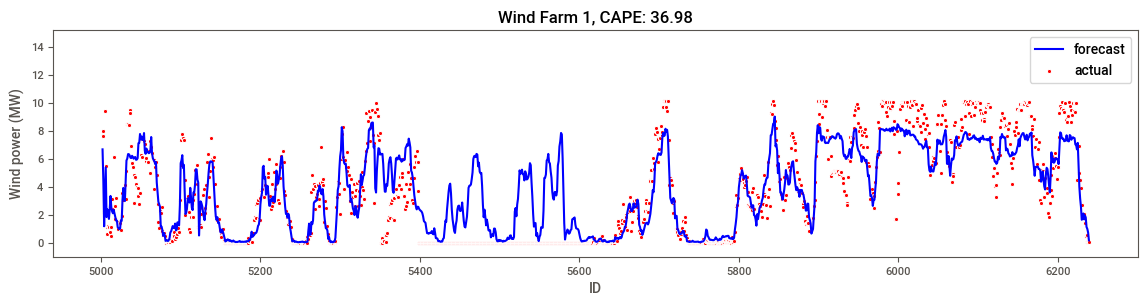

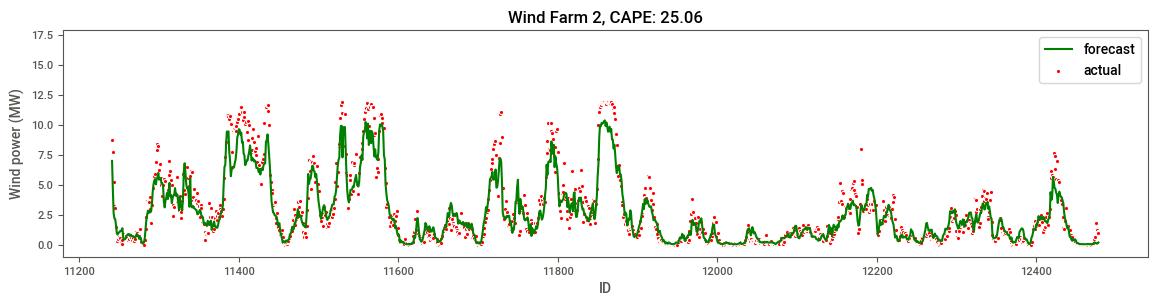

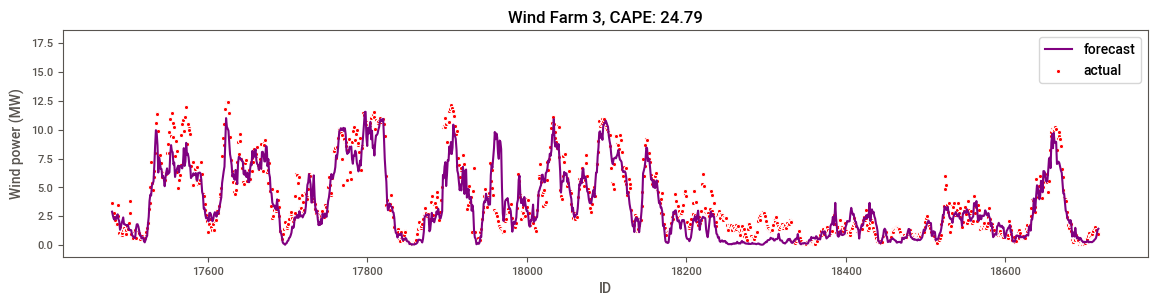

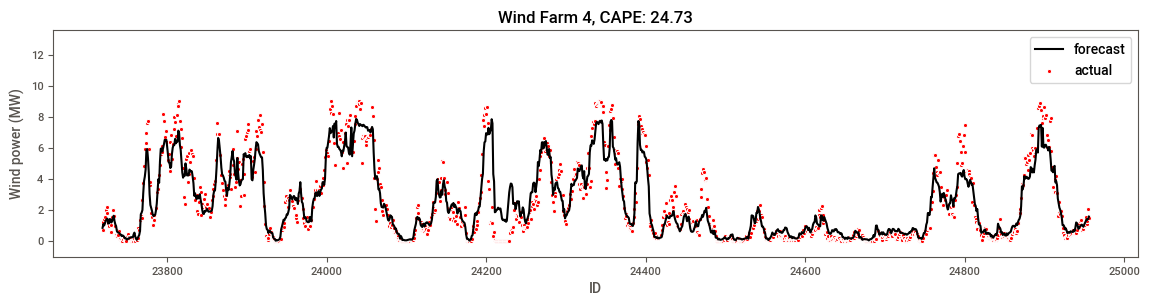

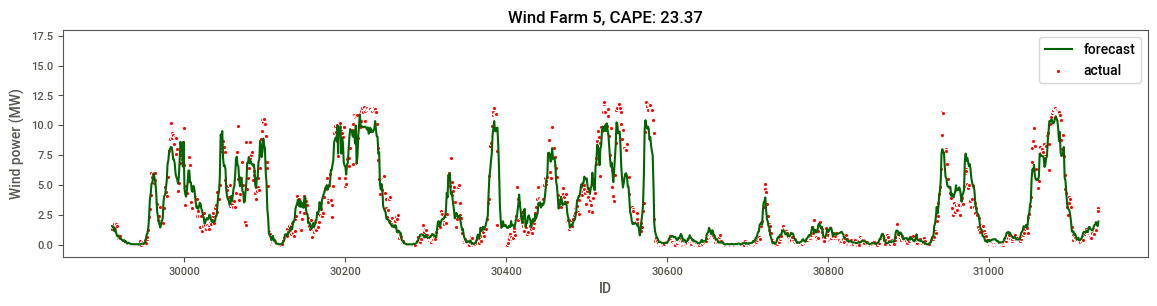

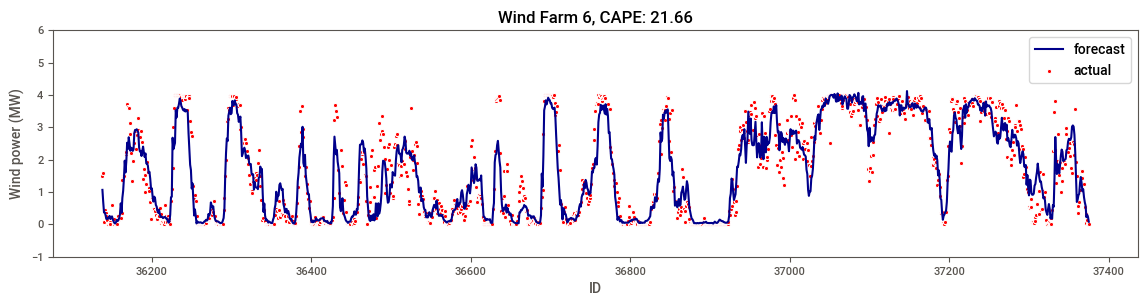

In [2862]:
# fig, ax = plt.subplot(6, 1, figsize=(16,3))
pal = ['blue', 'green', 'purple', 'black', 'darkgreen', 'darkblue']
for i, WF in enumerate(data.WF.unique()):
    plt.figure(figsize=(14,3))
    data_temp = data[data.WF == WF]
    ax1 = sns.lineplot(x='ID', y='prod_pred', color= pal[i], data=data_temp, label='forecast')
    sns.scatterplot(x='ID', y='prod_true', color='r', data=data_temp, ax=ax1, label='actual')
    plt.title('Wind Farm '+str(i+1)+ ', CAPE: '+str(round(cape_func(data_temp.prod_true.values,
                                                                   data_temp.prod_pred.values), 2)))
    plt.ylim([-1, max(data_temp['prod_true']*1.5)])
    plt.xlabel('ID')
    plt.ylabel('Wind power (MW)')
#     plt.savefig(WF+'_b.png)

##### Feature importance

In [2847]:
df_x = pd.DataFrame(df_Xtrain.values, columns=df_Xtrain.columns)

df_y = pd.DataFrame(df_ytrain_processed.values, columns=['Production'])

In [2848]:
df_Xtr = pd.concat([df_x, df_y], axis=1)

In [2849]:
my_report = sweetviz.analyze([df_Xtr, "Train"])

:FEATURES DONE:                    |                     | [  0%]   00:07  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:02  -> (00:00 left)


Creating Associations graph... DONE!


In [2850]:
my_report.show_html("train_Report.html")

###  Make forecast from test data

In [2851]:
X_train_all = df_Xtrain.values
y_train_all = df_ytrain_processed.values.ravel()

X_test = df_Xtest.values

In [2852]:
xgb_model = xgb.XGBRegressor(n_estimators=240, learning_rate=0.05, objective="count:poisson",
                             random_state=42)

In [2853]:
%%time
xgb_model.fit(X_train_all, y_train_all.ravel())

Wall time: 13.3 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0.699999988, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=240, n_jobs=0, num_parallel_tree=1,
             objective='count:poisson', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [2854]:
y_pred = xgb_model.predict(X_test)

In [2855]:
df_ytest2 = df_ytest.copy()

In [2856]:
df_ytest2['Production'] = y_pred